## Setup

In [1]:
import os
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import re
from community import community_louvain

In [2]:
#importing english language module for spacy

!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


We shall be using Spacy's 'en_core_web_sm' model for our entity recognition for all the entities present in the five Percy Jackson books.

In [3]:
#Named Entity Recognition Model

NER = spacy.load('en_core_web_sm')

## Functions

In [4]:
#function to create a document to store the output of the NER model

def create_book_doc(all_books, i):
    
    book = all_books[i]
    book_text = open(book, encoding="mbcs").read()
    book_doc = NER(book_text)
    return book_doc

In [5]:
#function to filter named entities from entity_list

def filter_entity(entity_list, character_df):
    return [entity for entity in entity_list
            if entity in list(character_df.character)
            or entity in list(character_df.character_firstname)]
            

In [6]:
#function to create entity_list and return a dataframe of entity_list for each sentence in a book

def create_sentence_entity_df(book_doc): 
    
    #create a df with the sentences and entities per sentence in a book
    sentence_entity_df = []

    for sentence in book_doc.sents:
        entity_list = [entity.text for entity in sentence.ents]
        sentence_entity_df.append({'sentence': sentence, 'entities': entity_list})
        
    sentence_entity_df = pd.DataFrame(sentence_entity_df)

    
    #filter out only the named entities from entity_list
    sentence_entity_df['character_entities'] = sentence_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))
        
    #filter out empty entities
    sentence_entity_df = sentence_entity_df[sentence_entity_df['character_entities'].map(len) > 0]
    
    #convert a fullname to firstname only
    sentence_entity_df['character_entities'] = sentence_entity_df['character_entities'].apply(
                                                    lambda x: [item.split()[0] for item in x])
    
    return sentence_entity_df

In [7]:
#function to create relationships between entities 

def create_relationship_df(sentence_entity_df_filtered):

    window_size = 5
    character_list = []
    relationships = []

    for i in range(0, sentence_entity_df_filtered.index[-1]):
        end_i = min(i + 5, sentence_entity_df_filtered.index[-1])
        character_list = sum((sentence_entity_df_filtered.loc[i: end_i].character_entities), [])

        character_list_unique = [character_list[i] for i in range(len(character_list))
                                 if(i==0) or character_list[i] != character_list[i-1]]

        #now let us create the source and target of the relationships

        if len(character_list_unique) > 1:
            for idx, a in enumerate(character_list_unique[:-1]):
                b = character_list_unique[idx + 1]
                relationships.append({'source': a, 'target': b})
               
    relationship_df = pd.DataFrame(relationships)
    
    return relationship_df

In [8]:
#function to create an edgelist dataframe

def create_edgelist(relationship_df):
    
    #change reversed relations i.e. b->a to a->b
    relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis=1), 
                                          columns = relationship_df.columns)
    
    #adding edge weights
    relationship_df['value'] = 1
    relationship_df = relationship_df.groupby(['source', 'target'], sort=False, as_index=False).sum()
    
    return relationship_df

In [9]:
#function to create a graph visualization

def create_community_graph(relationship_df, i):
    
    G = nx.from_pandas_edgelist(relationship_df,
                            source = 'source',
                            target = 'target',
                            edge_attr = 'value',
                            create_using = nx.Graph())
    
    #store degree of each node as an attribute for size
    node_degree = dict(G.degree)
    nx.set_node_attributes(G, node_degree, 'size')
    
    #create communities
    communities = community_louvain.best_partition(G, random_state=99)
    nx.set_node_attributes(G, communities, 'group')
    
    #display and save the graph visualization
    community_network = Network(notebook = True, width = '1000px', height = '700px', bgcolor = '#222222', font_color = 'white')
    community_network.from_nx(G)
    community_network.save_graph(f'Graphs/Community_relationships_{i}.html')
#     community_network.show(f'Community_relationships_{i}.html')
    
    return community_network, G
    

## Reading the books

We need to read through each of the books and store data about the entities in each sentence of the book. For now, let us work with the first book, i.e. Book 1 The Lightning Thief.

In [10]:
all_books = [b for b in os.scandir('Books') if '.txt' in b.name]

In [11]:
all_books

[<DirEntry 'Book 1 The Lightning Thief.txt'>,
 <DirEntry 'Book 2 Sea of Monsters.txt'>,
 <DirEntry "Book 3 The Titan's Curse.txt">,
 <DirEntry 'Book 4 The Battle of the Labyrinth.txt'>,
 <DirEntry 'Book 5 The Last Olympian.txt'>]

## Book 1

For the demonstration of the graph building and its visualization, let us only work with Book 1. 
Let us try out our NER model on it.

In [12]:
book_1 = all_books[0]
book_text_1 = open(book_1, encoding="mbcs").read()
book_doc_1 = NER(book_text_1)

Now let us visualize the entities that were identified.

In [13]:
displacy.render(book_doc_1[598:640], style='ent', jupyter=True)

As we can see, the model labelled most of the entities accurately. Now let us load the characters we scraped from the wiki.

In [14]:
character_df = pd.read_csv('Books/characters.csv')
character_df

,Unnamed: 0,book,character
0,0,Category:The Lightning Thief characters,Alecto
1,1,Category:The Lightning Thief characters,Annabeth Chase
2,2,Category:The Lightning Thief characters,Ares
3,3,Category:The Lightning Thief characters,Argus
4,4,Category:The Lightning Thief characters,Barbara Walters
...,...,...,...
432,432,Category:The Last Olympian characters,Triton
433,433,Category:The Last Olympian characters,Typhon
434,434,Category:The Last Olympian characters,Tyson
435,435,Category:The Last Olympian characters,William H. Seward's Statue


Here we see that there is information included within parentheses for certain characters, and a few of them are referred to with their prefix of Mr/Mrs/Ms/Dr. The rest are written with both their full name, and their first name. Let us extract the first names of these characters.

In [15]:
#removing prefixes, brackets and extra text from the names

character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))

character_df['character_firstname'] = character_df['character'].apply(
                lambda x: x if x.startswith('Mr. ') 
                else (x if x.startswith('Mrs. ') 
                else (x if x.startswith('Ms. ') 
                else (x if x.startswith('Dr. ') 
                else x.split(' ', 1)[0] ) )) )




# pd.set_option('display.max_rows', None)
character_df

,Unnamed: 0,book,character,character_firstname
0,0,Category:The Lightning Thief characters,Alecto,Alecto
1,1,Category:The Lightning Thief characters,Annabeth Chase,Annabeth
2,2,Category:The Lightning Thief characters,Ares,Ares
3,3,Category:The Lightning Thief characters,Argus,Argus
4,4,Category:The Lightning Thief characters,Barbara Walters,Barbara
...,...,...,...,...
432,432,Category:The Last Olympian characters,Triton,Triton
433,433,Category:The Last Olympian characters,Typhon,Typhon
434,434,Category:The Last Olympian characters,Tyson,Tyson
435,435,Category:The Last Olympian characters,William H. Seward's Statue,William


We have succesfully gotten the names of the characters the way they have been mentioned in the books.

## Entitiy list per sentence in the books

Now let us create a list of all the entities per sentence present in the books. Spacy has recognized all the entities, and we shall collate the entities that are useful to us, i.e. the names. We shall again just work with Book 1.

In [16]:
sentence_entity_df = []

for sentence in book_doc_1.sents:
    entity_list = [entity.text for entity in sentence.ents]
    sentence_entity_df.append({'sentence': sentence, 'entities': entity_list})

In [17]:
sentence_entity_df_book_1 = pd.DataFrame(sentence_entity_df)
sentence_entity_df_book_1

,sentence,entities
0,"(\n\n, Copyright, Â, ©, 2005, by, Rick, Riorda...",[Rick Riordan]
1,"(No, part, of, this, book, may, be, reproduced...",[]
2,"(For, information, address, Hyperion, Books, f...","[Hyperion Books for Children, Fifth Avenue, Ne..."
3,"(\n\n, First, Edition, \n, 579, 10, 8, 6, \n\n...","[10, 8 6, the United States of America, Congre..."
4,"(\n\n, ISBN, 0, -, 7868, -, 5629, -, 7, (, har...","[0-7868-5629-7, To Haley, 16, â€¢ Grover Unexp..."
...,...,...
9715,"(Thanks, to, my, \n, elder, son, ,, Haley, Mic...","[Haley Michael, first]"
9716,"(Patrick, John, ,, who, at, the, age, of, six,...","[Patrick John, the age of six, one, Becky, man..."
9717,"(Thanks, also, \n, to, my, cadre, of, middle-,...","[Travis Stoll, Hermes, C. C. Kellogg, Athena, ..."
9718,"(My, appreciation, also, to, Professor, \n, Eg...","[Egbert J. Bakker, Nancy Gallt, summa cum laud..."


The dataframe above shows all the sentences and the entities present in them from Book 1. We are only interested with entities that are characters. Let us filter this dataframe.

In [18]:
sentence_entity_df_book_1['character_entities'] = sentence_entity_df_book_1['entities'].apply(
                                                        lambda x: filter_entity(x, character_df))
    
sentence_entity_df_book_1

,sentence,entities,character_entities
0,"(\n\n, Copyright, Â, ©, 2005, by, Rick, Riorda...",[Rick Riordan],[]
1,"(No, part, of, this, book, may, be, reproduced...",[],[]
2,"(For, information, address, Hyperion, Books, f...","[Hyperion Books for Children, Fifth Avenue, Ne...",[]
3,"(\n\n, First, Edition, \n, 579, 10, 8, 6, \n\n...","[10, 8 6, the United States of America, Congre...",[]
4,"(\n\n, ISBN, 0, -, 7868, -, 5629, -, 7, (, har...","[0-7868-5629-7, To Haley, 16, â€¢ Grover Unexp...",[]
...,...,...,...
9715,"(Thanks, to, my, \n, elder, son, ,, Haley, Mic...","[Haley Michael, first]",[]
9716,"(Patrick, John, ,, who, at, the, age, of, six,...","[Patrick John, the age of six, one, Becky, man...",[]
9717,"(Thanks, also, \n, to, my, cadre, of, middle-,...","[Travis Stoll, Hermes, C. C. Kellogg, Athena, ...","[Travis Stoll, Hermes, Athena]"
9718,"(My, appreciation, also, to, Professor, \n, Eg...","[Egbert J. Bakker, Nancy Gallt, summa cum laud...",[Percy]


There are multiple character_entities that are empty. Let us filter them out. 

In [19]:
sentence_entity_df_filtered_book_1 = sentence_entity_df_book_1[sentence_entity_df_book_1['character_entities'].map(len) > 0]
sentence_entity_df_filtered_book_1

,sentence,entities,character_entities
21,"(\n\n, My, name, is, Percy, Jackson, .)",[Percy Jackson],[Percy Jackson]
46,"(\n\n, All, the, way, into, the, city, ,, I, p...","[Nancy Bobofit, kleptomaniac]",[Nancy Bobofit]
55,"(\n\n, Anyway, ,, Nancy, Bobofit, was, throwin...",[Nancy Bobofit],[Nancy Bobofit]
61,"(\n\n, He, dodged, another, piece, of, Nancy, ...",[Nancy],[Nancy]
66,"(\n\n, Looking, back, on, it, ,, I, wish, I, '...","[Nancy Bobofit, 3]",[Nancy Bobofit]
...,...,...,...
9696,"(\n\n, "", Sounds, like, a, plan, worthy, of, A...",[Athena],[Athena]
9704,"(She, touched, Thalia, 's, pine, tree, ,, then...",[Thalia],[Thalia]
9709,"(\n\n, I, wondered, ,, if, Poseidon, were, wat...",[Poseidon],[Poseidon]
9717,"(Thanks, also, \n, to, my, cadre, of, middle-,...","[Travis Stoll, Hermes, C. C. Kellogg, Athena, ...","[Travis Stoll, Hermes, Athena]"


We can see that we have two seperate entities for characters due to the fact that they are referred to with their full name as well as their first name ('Percy Jackson' and 'Percy' are two seperate entities). Let us take the first name of all the entities to keep the entities consistent.

In [20]:
sentence_entity_df_filtered_book_1['character_entities'] = sentence_entity_df_filtered_book_1['character_entities'].apply(
                                                    lambda x: [item.split()[0] for item in x])

sentence_entity_df_filtered_book_1

C:\Users\varun\AppData\Local\Temp\ipykernel_29084\2519888507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentence_entity_df_filtered_book_1['character_entities'] = sentence_entity_df_filtered_book_1['character_entities'].apply(


,sentence,entities,character_entities
21,"(\n\n, My, name, is, Percy, Jackson, .)",[Percy Jackson],[Percy]
46,"(\n\n, All, the, way, into, the, city, ,, I, p...","[Nancy Bobofit, kleptomaniac]",[Nancy]
55,"(\n\n, Anyway, ,, Nancy, Bobofit, was, throwin...",[Nancy Bobofit],[Nancy]
61,"(\n\n, He, dodged, another, piece, of, Nancy, ...",[Nancy],[Nancy]
66,"(\n\n, Looking, back, on, it, ,, I, wish, I, '...","[Nancy Bobofit, 3]",[Nancy]
...,...,...,...
9696,"(\n\n, "", Sounds, like, a, plan, worthy, of, A...",[Athena],[Athena]
9704,"(She, touched, Thalia, 's, pine, tree, ,, then...",[Thalia],[Thalia]
9709,"(\n\n, I, wondered, ,, if, Poseidon, were, wat...",[Poseidon],[Poseidon]
9717,"(Thanks, also, \n, to, my, cadre, of, middle-,...","[Travis Stoll, Hermes, C. C. Kellogg, Athena, ...","[Travis, Hermes, Athena]"


In [21]:
sentence_entity_df_book_1 = sentence_entity_df_filtered_book_1

## Creating relationships between the characters

Now that we have a list of all the characters in the first book, let us see all the characters that appear within a window of a number of sentences. The characters that appear in this window will tend to have a relationship with one another.

In [22]:
window_size = 5
character_list = []
relationships = []
for i in range(0, sentence_entity_df_book_1.index[-1]):
    end_i = min(i + window_size, sentence_entity_df_book_1.index[-1])
    character_list = sum((sentence_entity_df_book_1.loc[i: end_i].character_entities), [])
    
#     if i > 1000 and i < 2000:    #we see that there are entity lists that have two of the same entity in the list. 
#         print(character_list)    #We aren't interested in entity relationships with oneself so let us remove them


    character_list_unique = [character_list[i] for i in range(len(character_list))
                             if(i==0) or character_list[i] != character_list[i-1]]
    
    #now let us create the source and target of the relationships
    
    if len(character_list_unique) > 1:
        for idx, a in enumerate(character_list_unique[:-1]):
            b = character_list_unique[idx + 1]
            relationships.append({'source': a, 'target': b})

In [23]:
relationship_df_book_1 = pd.DataFrame(relationships)
relationship_df_book_1

,source,target
0,Titan,Zeus
1,Titan,Zeus
2,Titan,Zeus
3,Zeus,Nancy
4,Zeus,Nancy
...,...,...
1583,Hermes,Athena
1584,Athena,Percy
1585,Travis,Hermes
1586,Hermes,Athena


We now have a dataframe of the relationships between the characters of Book 1. Here, we see that there are many "reversed relationships (like "Nancy" -> "Percy" and "Percy -> "Nancy"). Let us sort these relationships so that we can aggregate them easily. 

In [24]:
relationship_df_book_1 = pd.DataFrame(np.sort(relationship_df_book_1.values, axis=1), columns = relationship_df_book_1.columns)
relationship_df_book_1

,source,target
0,Titan,Zeus
1,Titan,Zeus
2,Titan,Zeus
3,Nancy,Zeus
4,Nancy,Zeus
...,...,...
1583,Athena,Hermes
1584,Athena,Percy
1585,Hermes,Travis
1586,Athena,Hermes


Let us assume that each relation two entities have with each other is of a certain value (say 1). Hence the more the number of relations, the stronger the relationship is. Let us have this value as the weight of the relationship.

In [25]:
relationship_df_book_1['value'] = 1
relationship_df_book_1 = relationship_df_book_1.groupby(['source', 'target'], sort=False, as_index=False).sum()

relationship_df_book_1

,source,target,value
0,Titan,Zeus,25
1,Nancy,Zeus,2
2,Grover,Nancy,6
3,Nancy,Percy,8
4,Charon,Chiron,6
...,...,...,...
147,Artemis,Zeus,6
148,Apollo,Artemis,6
149,Percy,Tartarus,6
150,Poseidon,Thalia,1


We have created a dataframe of all the relationships in Book 1 and the "weight" of each relationship. Now we can visualize this dataframe as a graph.

## Graph visualization

Let us start off by using the graph visualization tool from networkx, and then use Pyvis to improve on it. 

In [26]:
#list to store all 5 graphs

books_graphs = []

In [27]:
G_1 = nx.from_pandas_edgelist(relationship_df_book_1,
                            source = 'source',
                            target = 'target',
                            edge_attr = 'value',
                            create_using = nx.Graph())
books_graphs.append(G_1)

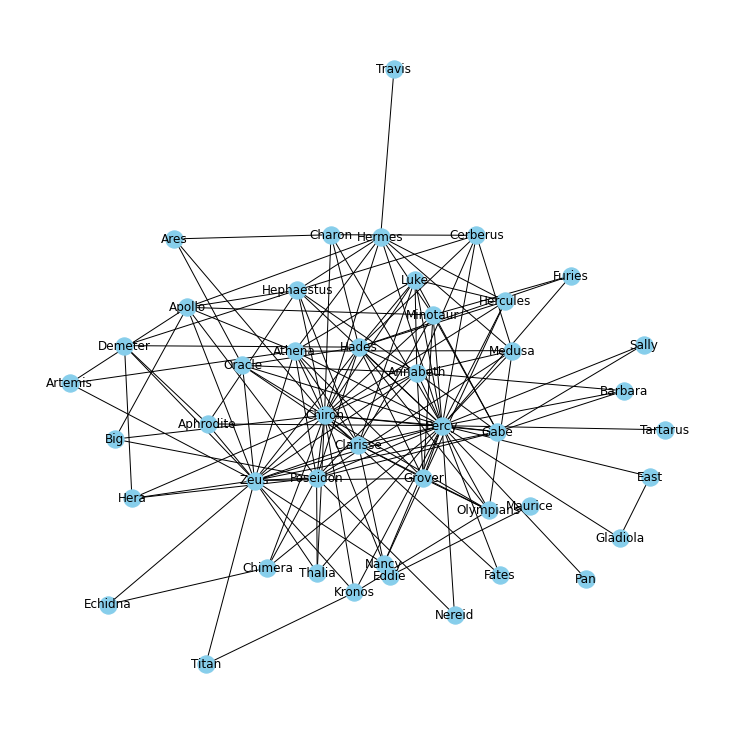

In [28]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G_1)
nx.draw(G_1, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

The above graph shows the relationships between the characters, but is not easy to analyze as it isn't very intuitive. We can use Pyvis to create a better visualization for the graph.

In [29]:
network = Network(notebook = True, width = '1000px', height = '700px', bgcolor = '#222222', font_color = 'white')
node_degree = dict(G_1.degree)
nx.set_node_attributes(G_1, node_degree, 'size')

network.from_nx(G_1)

network.save_graph('Graphs/relationships.html')
network.show('relationships.html')

From this graph, we can extract information such as the more important characters (as denoted by larger nodes), and the importance of relationships between characters (as denoted by the thickness, or weight of the edge).

We can further visualize the importance of the characters over the course of the book by using centrality measures. The measures we shall visualize shall be:
* __Degree Centrality__: The measure of the number of incoming and outgoing edges to a node. Higher the degree centrality, the more relationships the node has with other nodes.
* __Betweenness Centrality__: The measure of the amount of influence a node has over the flow of information in a graph. Nodes that more frequently lie on shortest paths between other nodes will have higher betweenness centrality scores.
* __Closeness Centrality__: The measure of average inverse distance to all other nodes. Higher closeness centrality implies the node has a shorter distance from other nodes.

In [30]:
#degree centrality
degree_dict = nx.degree_centrality(G_1)
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
degree_dict = dict(sorted(degree_dict.items(), key = lambda item : item[1], reverse=True))
degree_dict_10 = dict(list(degree_dict.items())[0:10])


#betweenness centrality
between_dict = nx.betweenness_centrality(G_1)
between_df = pd.DataFrame.from_dict(between_dict, orient='index', columns=['centrality'])
between_dict = dict(sorted(between_dict.items(), key = lambda item : item[1], reverse=True))
between_dict_10 = dict(list(between_dict.items())[0:10])

#closeness centrality
closeness_dict = nx.closeness_centrality(G_1)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
closeness_dict = dict(sorted(closeness_dict.items(), key = lambda item : item[1], reverse=True))
closeness_dict_10 = dict(list(closeness_dict.items())[0:10])

Text(0.5, 1.0, 'Closeness Centrality')

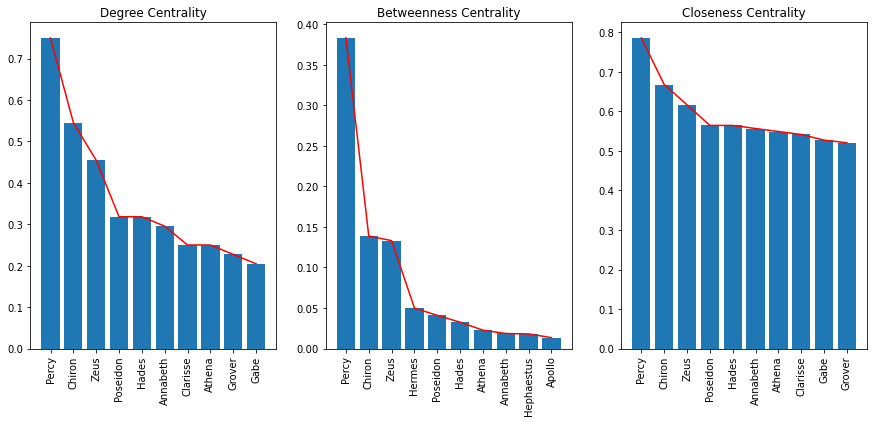

In [31]:
#plotting the top 10 nodes for each centrality

fig, ax = plt.subplots(1, 3, figsize=(15, 6))

# ax[0].figure(figsize=(6,6))
X_degree = degree_dict_10.keys()
Y_degree = degree_dict_10.values()
ax[0].plot(X_degree, Y_degree, 'r')
ax[0].bar(X_degree, Y_degree)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title('Degree Centrality')
# plt.show()


# ax[1].figure(figsize=(6,6))
X_between = between_dict_10.keys()
Y_between = between_dict_10.values()
ax[1].plot(X_between, Y_between, 'r')
ax[1].bar(X_between, Y_between)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title('Betweenness Centrality')
# plt.show()


# ax[2].figure(figsize=(6,6))
X_closeness = closeness_dict_10.keys()
Y_closeness = closeness_dict_10.values()
ax[2].plot(X_closeness, Y_closeness, 'r')
ax[2].bar(X_closeness, Y_closeness)
ax[2].tick_params(axis='x', labelrotation=90)
ax[2].set_title('Closeness Centrality')
# plt.show()

Here we can see that the main characters of the book are relatively the same across the three measures. Some insights that we can extract from these graphs:

* The importance of the main 10 characters decreases steadily.
* The character with the highest betweenness centrality is Percy, implying that he is the character through which the most information is passed through to the other characters. Even the second highest character Chiron has a significantly lower betweeness centrality in comparision.
* The main 10 characters by closeness centrality all have high measures, indicating that the information amongst each of them travels fast, and from the graph visualized above, we can say that their induvidual networks are highly dense.

From these insights, we can understand that there will be certain communities within the entire graph of the characters. Let us try to visualize how these communities interact with each other.

## Community Detection

In [32]:
communities = community_louvain.best_partition(G_1, random_state=99)
communities

{'Titan': 1,
 'Zeus': 1,
 'Nancy': 4,
 'Grover': 4,
 'Percy': 0,
 'Charon': 4,
 'Chiron': 4,
 'Gabe': 0,
 'Sally': 0,
 'Minotaur': 4,
 'Annabeth': 3,
 'Olympians': 4,
 'Hera': 1,
 'Hercules': 4,
 'Hermes': 3,
 'Clarisse': 4,
 'Oracle': 4,
 'Luke': 4,
 'Athena': 1,
 'Poseidon': 1,
 'Ares': 4,
 'Apollo': 1,
 'Hephaestus': 3,
 'Hades': 4,
 'Thalia': 1,
 'Demeter': 1,
 'Aphrodite': 1,
 'Big': 1,
 'Kronos': 1,
 'Fates': 0,
 'Medusa': 3,
 'Pan': 0,
 'Gladiola': 0,
 'East': 0,
 'Chimera': 1,
 'Echidna': 1,
 'Artemis': 1,
 'Eddie': 2,
 'Maurice': 2,
 'Furies': 4,
 'Nereid': 0,
 'Barbara': 0,
 'Cerberus': 3,
 'Tartarus': 0,
 'Travis': 3}

In [33]:
nx.set_node_attributes(G_1, communities, 'group')

In [34]:
community_network = Network(notebook = True, width = '1000px', height = '700px', bgcolor = '#222222', font_color = 'white')
community_network.from_nx(G_1)
community_network.save_graph('Graphs/Community_relationships_1.html')

community_network.show('Graphs/Community_relationships_1.html')

With this visualization, we can easily "cluster" the characters in the book and see which characters have a community of their own and how these communities interact with each other. From the above visualization we can see that there are a few main communities, specifically Red, Blue, Green and Yellow. 

Red being Percy's community makes sense as he is the protagonist of the book and definitely would have the highest relationships with other smaller characters.

Blue being a community comprising of characters like Zeus and Poseidon also makes sense as these are all the "Olympian Gods". The members of this community interact with each other more often than interacting with the other characters of the book. 

Green being the community of Annabeth also is viable as she is arguably the second main protagonist of the book, helping Percy in his adventures. Thus she has her own connections, seperate from those of Percy's

Finally, Yellow seems to be the comumnity of the other characters in Percy's camp. These seem to be the people that have a lower interaction with Percy over the course of the book, and tend to be mentioned quite less. 

## Books 2-5

Now, lets create similar graphs for the remaining four books and see if we can find any patterns over all five books.

In [35]:
book_doc_2 = create_book_doc(all_books, 1)
book_doc_3 = create_book_doc(all_books, 2)
book_doc_4 = create_book_doc(all_books, 3)
book_doc_5 = create_book_doc(all_books, 4)

In [36]:
sentence_entity_df_book_2 = create_sentence_entity_df(book_doc_2)
sentence_entity_df_book_3 = create_sentence_entity_df(book_doc_3)
sentence_entity_df_book_4 = create_sentence_entity_df(book_doc_4)
sentence_entity_df_book_5 = create_sentence_entity_df(book_doc_5)

In [37]:
relationships_df_book_2 = create_relationship_df(sentence_entity_df_book_2)
relationships_df_book_3 = create_relationship_df(sentence_entity_df_book_3)
relationships_df_book_4 = create_relationship_df(sentence_entity_df_book_4)
relationships_df_book_5 = create_relationship_df(sentence_entity_df_book_5)

In [38]:
relationships_df_book_2 = create_edgelist(relationships_df_book_2)
relationships_df_book_3 = create_edgelist(relationships_df_book_3)
relationships_df_book_4 = create_edgelist(relationships_df_book_4)
relationships_df_book_5 = create_edgelist(relationships_df_book_5)

#### Graph visualization for Book 2

In [39]:
community_network_book_2, G_2 = create_community_graph(relationships_df_book_2, 2)
books_graphs.append(G_2)

community_network_book_2.show('Graphs/Community_relationships_2.html')

#### Graph visualization for Book 3

In [40]:
community_network_book_3, G_3 = create_community_graph(relationships_df_book_3, 3)
books_graphs.append(G_3)

community_network_book_3.show('Graphs/Community_relationships_3.html')

#### Graph visualization for Book 4

In [41]:
community_network_book_4, G_4 = create_community_graph(relationships_df_book_4, 4)
books_graphs.append(G_4)

community_network_book_4.show('Graphs/Community_relationships_4.html')

#### Graph visualization for Book 5

In [42]:
community_network_book_5, G_5 = create_community_graph(relationships_df_book_5, 5)
books_graphs.append(G_5)
community_network_book_5.repulsion()                                   #added because the physics engine was going crazy

community_network_book_5.show('Graphs/Community_relationships_5.html')

Let us see some trends of the main characters that can be extracted from these graphs.

In [43]:
books_graphs


In [44]:
degs = [nx.degree_centrality(graph) for graph in books_graphs]
degs_df = pd.DataFrame(degs)


degs_df

,Titan,Zeus,Nancy,Grover,Percy,Charon,Chiron,Gabe,Sally,Minotaur,...,Elpis,Morrain,Hyperion,Hyperborean,Larry,Owen,Bobby,Lydian,Party,Hunters
0,0.045455,0.454545,0.113636,0.227273,0.750000,0.113636,0.545455,0.204545,0.045455,0.181818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.189655,NaN,0.086207,0.500000,NaN,0.275862,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.176471,0.392157,NaN,0.137255,0.372549,NaN,0.470588,0.039216,0.039216,0.019608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.126761,0.140845,NaN,0.042254,0.309859,NaN,0.408451,NaN,0.028169,0.014085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.296703,0.263736,NaN,0.054945,0.450549,0.010989,0.318681,NaN,0.010989,0.043956,...,0.010989,0.010989,0.032967,0.032967,0.021978,0.010989,0.010989,0.010989,0.021978,0.021978


<AxesSubplot:>

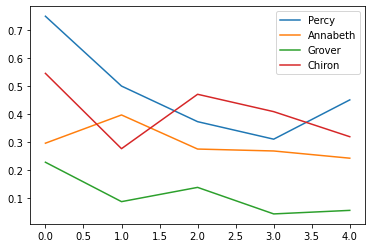

In [45]:
degs_df[['Percy', 'Annabeth', 'Grover', 'Chiron']].plot()

Some interesting trends to point out here:
* As expected, Percy had the highest degree centrality at the start and end of the 5 books. However in book 3 and 4, Chiron seems to have overtaken in degree centrality. This indicates that Chiron's character had more interactions with characters in those books compared to Percy.
* Annabeth's degree centrality seems to be relatively constant throughout the 5 books, only peaking in book 2. Thus a strong assumption could be that her character had more interactions in book 2 compared to the remaining.
* One would assume that Grover, who is supposed to be Percy's sidekick, would have a higher degree centrality, but from the above graph it is evident that he doesn't have much of a role in the series. 

In conclusion, we can see how the community graph visualizations can show us interesting patterns and bring up key points to check for to further showcase trends in the characters of the 5 book series. This notebook serves to show how such visualizations can be useful.